# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

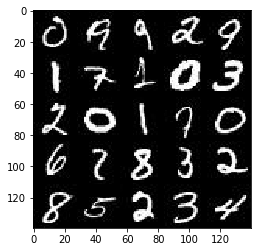

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

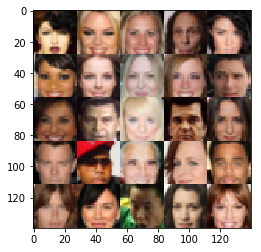

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, name = 'learn_rate')

    return input_real, input_z, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # 参考：DCGAN paper - https://arxiv.org/pdf/1511.06434.pdf
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        '''
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        '''
        '''review suggestion
        如果要进一步的提升模型的效率，可以使用0.8概率的dropout和用Xavier初始化权重。
        Xavier可以通过下面的方法实现，在tf.layers.conv2d中，将-tf.contrib.layers.xavier_initializer()
        传入作为kernel_initializerparameter的值。
        Xavier可以加速你的模型收敛的过程，因为这个例子中，我们故意选择了较小的epoch，鼓励你们能够优化模型达到不错的效果，
        所以如果使用了更好的权重初始化方法，就由可能获得更好的结果。
        其次，Xavier有可能增加模型收敛到更低的loss的可能性。
        '''
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.8)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        x2 = tf.nn.dropout(x2, keep_prob=0.8)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        x3 = tf.nn.dropout(x3, keep_prob=0.8)
        # 4x4x256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # 参考：DCGAN paper - https://arxiv.org/pdf/1511.06434.pdf
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.8)
        # 2x2x512 now

        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.8)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.8)
        # 14x14x128 now

        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3(channel)now

        out = tf.tanh(logits)
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    """review suggestion
    为了防止discriminator太强，同时也为了让它能够更有泛化能力，一般会将disc_label_real乘以0.9。这叫做标签的（单侧）平滑化。
    也可以通过labels = tf.ones_like(tensor) * (1 - smooth) 来实现。
    """
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth=0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    # 参考：https://github.com/udacity/cn-deep-learning/blob/master/tutorials/dcgan-svhn/DCGAN.ipynb
    
    samples, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                """review suggestion
                这里由于generator的输出应用了tanh，tanh函数输出在-1到1之间，但是batch_images的范围在-0.5到0.5之间，
                所以这个地方需要将real image的范围rescale到-1到1之间，这里可以通过batch_images = batch_images*2来实现，
                这样给discriminator传入的real image和generator的fake image就在相同的范围了
                """
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size = [batch_size, z_dim])
                               
                feed_dict = {input_real: batch_images,input_z: batch_z,learn_rate: learning_rate}
                 # Run optimizers
                _ = sess.run(d_opt, feed_dict = feed_dict)
                _ = sess.run(g_opt, feed_dict = feed_dict)
                
                print_every = 10
                if steps % print_every == 0:
                    # 在每个epoch之后得到并打印losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                show_every = 100
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.9399... Generator Loss: 0.9804
Epoch 1/2... Discriminator Loss: 0.7842... Generator Loss: 1.3519
Epoch 1/2... Discriminator Loss: 0.6358... Generator Loss: 1.8861
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 2.9858
Epoch 1/2... Discriminator Loss: 0.5028... Generator Loss: 2.5225
Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 2.8645
Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 2.7264
Epoch 1/2... Discriminator Loss: 0.4032... Generator Loss: 3.4536
Epoch 1/2... Discriminator Loss: 0.3754... Generator Loss: 3.7252
Epoch 1/2... Discriminator Loss: 0.4231... Generator Loss: 2.9725


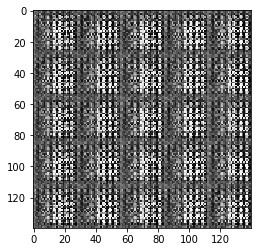

Epoch 1/2... Discriminator Loss: 0.4225... Generator Loss: 3.1306
Epoch 1/2... Discriminator Loss: 0.3796... Generator Loss: 3.5546
Epoch 1/2... Discriminator Loss: 0.3788... Generator Loss: 3.7018
Epoch 1/2... Discriminator Loss: 0.4319... Generator Loss: 2.8452
Epoch 1/2... Discriminator Loss: 0.3893... Generator Loss: 3.3998
Epoch 1/2... Discriminator Loss: 0.4328... Generator Loss: 2.8048
Epoch 1/2... Discriminator Loss: 0.4577... Generator Loss: 4.8464
Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 8.2005
Epoch 1/2... Discriminator Loss: 0.6898... Generator Loss: 1.6487
Epoch 1/2... Discriminator Loss: 0.6585... Generator Loss: 2.0054


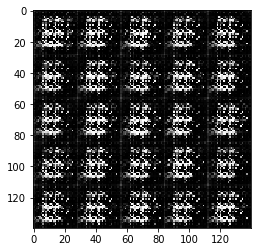

Epoch 1/2... Discriminator Loss: 0.4183... Generator Loss: 3.4178
Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 3.9961
Epoch 1/2... Discriminator Loss: 0.4537... Generator Loss: 3.3566
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 2.4937
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 1.2248
Epoch 1/2... Discriminator Loss: 0.5168... Generator Loss: 3.2494
Epoch 1/2... Discriminator Loss: 0.6228... Generator Loss: 2.0693
Epoch 1/2... Discriminator Loss: 0.8135... Generator Loss: 1.5918
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 2.4575
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 2.8408


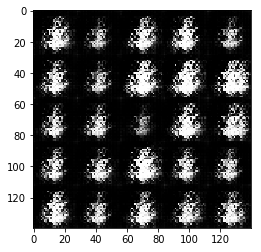

Epoch 1/2... Discriminator Loss: 0.6726... Generator Loss: 2.0720
Epoch 1/2... Discriminator Loss: 0.5861... Generator Loss: 2.1233
Epoch 1/2... Discriminator Loss: 0.5538... Generator Loss: 2.5801
Epoch 1/2... Discriminator Loss: 0.6251... Generator Loss: 2.2577
Epoch 1/2... Discriminator Loss: 0.5716... Generator Loss: 2.4267
Epoch 1/2... Discriminator Loss: 0.5566... Generator Loss: 2.5488
Epoch 1/2... Discriminator Loss: 0.4711... Generator Loss: 2.8555
Epoch 1/2... Discriminator Loss: 0.4839... Generator Loss: 2.4659
Epoch 1/2... Discriminator Loss: 0.5337... Generator Loss: 2.4942
Epoch 1/2... Discriminator Loss: 0.5389... Generator Loss: 2.5856


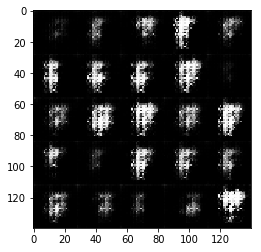

Epoch 1/2... Discriminator Loss: 0.5769... Generator Loss: 2.1523
Epoch 1/2... Discriminator Loss: 0.5004... Generator Loss: 2.5730
Epoch 1/2... Discriminator Loss: 0.5055... Generator Loss: 2.6835
Epoch 1/2... Discriminator Loss: 0.5869... Generator Loss: 2.0881
Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 2.3361
Epoch 1/2... Discriminator Loss: 0.4785... Generator Loss: 3.0800
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 3.4173
Epoch 1/2... Discriminator Loss: 0.5191... Generator Loss: 2.5139
Epoch 1/2... Discriminator Loss: 0.4561... Generator Loss: 3.1596
Epoch 1/2... Discriminator Loss: 0.5424... Generator Loss: 2.6978


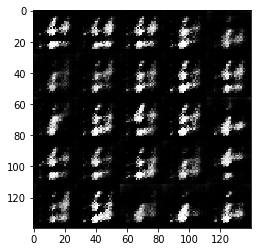

Epoch 1/2... Discriminator Loss: 0.4443... Generator Loss: 3.2449
Epoch 1/2... Discriminator Loss: 0.5406... Generator Loss: 2.5031
Epoch 1/2... Discriminator Loss: 0.5720... Generator Loss: 2.5971
Epoch 1/2... Discriminator Loss: 0.4942... Generator Loss: 2.9630
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 3.1698
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 2.3439
Epoch 1/2... Discriminator Loss: 0.6401... Generator Loss: 2.4014
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 2.2473
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 2.3764
Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 2.6230


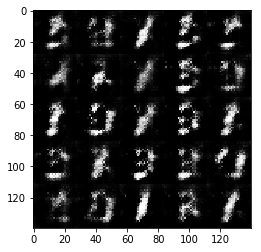

Epoch 1/2... Discriminator Loss: 0.7147... Generator Loss: 1.6695
Epoch 1/2... Discriminator Loss: 0.5827... Generator Loss: 2.2641
Epoch 1/2... Discriminator Loss: 0.5376... Generator Loss: 2.3620
Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 2.4649
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.7723
Epoch 1/2... Discriminator Loss: 0.8329... Generator Loss: 1.8023
Epoch 1/2... Discriminator Loss: 0.7856... Generator Loss: 1.3747
Epoch 1/2... Discriminator Loss: 0.6454... Generator Loss: 2.3270
Epoch 1/2... Discriminator Loss: 0.6734... Generator Loss: 2.3184
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.9136


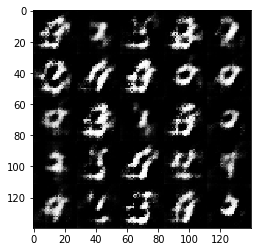

Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 2.2287
Epoch 1/2... Discriminator Loss: 0.7333... Generator Loss: 1.9927
Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 2.0450
Epoch 1/2... Discriminator Loss: 0.6848... Generator Loss: 1.9888
Epoch 1/2... Discriminator Loss: 0.6904... Generator Loss: 1.9248
Epoch 1/2... Discriminator Loss: 0.6832... Generator Loss: 2.3902
Epoch 1/2... Discriminator Loss: 0.6990... Generator Loss: 1.9511
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.8735
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.9820
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.7399


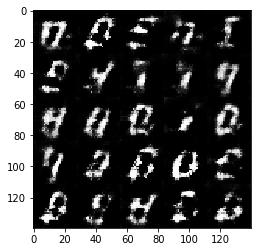

Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 1.6844
Epoch 1/2... Discriminator Loss: 0.6320... Generator Loss: 1.9869
Epoch 1/2... Discriminator Loss: 0.6295... Generator Loss: 2.7314
Epoch 1/2... Discriminator Loss: 0.6127... Generator Loss: 2.4023
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.6307... Generator Loss: 2.6839
Epoch 1/2... Discriminator Loss: 0.8394... Generator Loss: 1.5862
Epoch 1/2... Discriminator Loss: 0.5840... Generator Loss: 2.3835
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 1.4205
Epoch 1/2... Discriminator Loss: 0.8134... Generator Loss: 1.7965


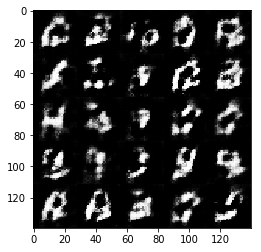

Epoch 1/2... Discriminator Loss: 0.7435... Generator Loss: 2.1110
Epoch 1/2... Discriminator Loss: 0.9184... Generator Loss: 1.4312
Epoch 1/2... Discriminator Loss: 0.7400... Generator Loss: 1.7405
Epoch 2/2... Discriminator Loss: 0.9327... Generator Loss: 1.5196
Epoch 2/2... Discriminator Loss: 0.8382... Generator Loss: 1.6923
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.8029
Epoch 2/2... Discriminator Loss: 0.8477... Generator Loss: 2.0888
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 2.0416
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 1.5592
Epoch 2/2... Discriminator Loss: 0.7401... Generator Loss: 2.0530


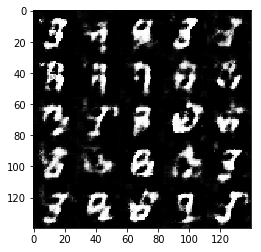

Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 1.8447
Epoch 2/2... Discriminator Loss: 0.8922... Generator Loss: 1.8253
Epoch 2/2... Discriminator Loss: 0.9166... Generator Loss: 1.4505
Epoch 2/2... Discriminator Loss: 0.9119... Generator Loss: 1.3203
Epoch 2/2... Discriminator Loss: 0.8003... Generator Loss: 1.8148
Epoch 2/2... Discriminator Loss: 0.8348... Generator Loss: 1.6334
Epoch 2/2... Discriminator Loss: 0.9128... Generator Loss: 1.6114
Epoch 2/2... Discriminator Loss: 0.8288... Generator Loss: 1.4262
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 2.2940
Epoch 2/2... Discriminator Loss: 0.7821... Generator Loss: 1.8265


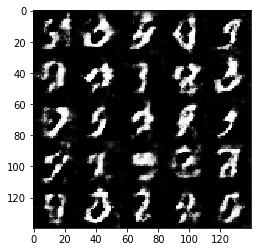

Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 2.2116
Epoch 2/2... Discriminator Loss: 0.8613... Generator Loss: 1.5201
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 1.7786
Epoch 2/2... Discriminator Loss: 0.8890... Generator Loss: 1.4232
Epoch 2/2... Discriminator Loss: 1.0375... Generator Loss: 1.7224
Epoch 2/2... Discriminator Loss: 1.0063... Generator Loss: 1.3876
Epoch 2/2... Discriminator Loss: 0.9434... Generator Loss: 1.7802
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.8189
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 1.9251


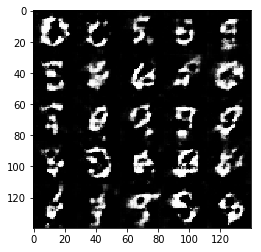

Epoch 2/2... Discriminator Loss: 0.9188... Generator Loss: 1.5456
Epoch 2/2... Discriminator Loss: 1.0592... Generator Loss: 1.6974
Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 1.3887
Epoch 2/2... Discriminator Loss: 0.9961... Generator Loss: 1.3037
Epoch 2/2... Discriminator Loss: 0.8431... Generator Loss: 1.6873
Epoch 2/2... Discriminator Loss: 1.2013... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.7900
Epoch 2/2... Discriminator Loss: 1.1422... Generator Loss: 1.4792
Epoch 2/2... Discriminator Loss: 0.8086... Generator Loss: 1.9788
Epoch 2/2... Discriminator Loss: 1.0055... Generator Loss: 1.4018


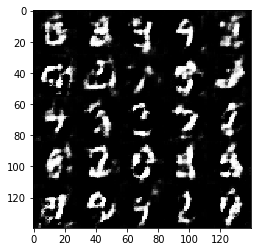

Epoch 2/2... Discriminator Loss: 0.7600... Generator Loss: 1.7565
Epoch 2/2... Discriminator Loss: 1.0572... Generator Loss: 1.0856
Epoch 2/2... Discriminator Loss: 1.0564... Generator Loss: 1.1001
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 1.6273
Epoch 2/2... Discriminator Loss: 0.9406... Generator Loss: 1.5783
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 1.4929
Epoch 2/2... Discriminator Loss: 1.0556... Generator Loss: 1.2211
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 1.6783
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 1.5348
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.2661


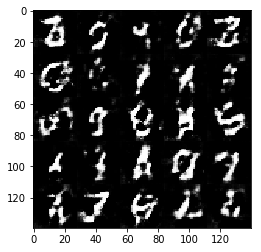

Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 1.2249
Epoch 2/2... Discriminator Loss: 0.8925... Generator Loss: 1.6061
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.3479
Epoch 2/2... Discriminator Loss: 1.1725... Generator Loss: 0.9666
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.3090
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 1.4040
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 1.1301
Epoch 2/2... Discriminator Loss: 0.9146... Generator Loss: 1.5221
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 1.6899
Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.4909


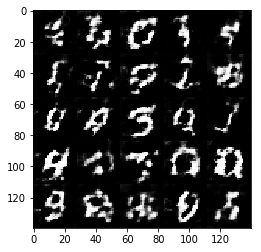

Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 1.4735
Epoch 2/2... Discriminator Loss: 1.1138... Generator Loss: 1.2133
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 1.3770
Epoch 2/2... Discriminator Loss: 1.2028... Generator Loss: 1.3971
Epoch 2/2... Discriminator Loss: 1.1048... Generator Loss: 1.4215
Epoch 2/2... Discriminator Loss: 0.8495... Generator Loss: 1.7607
Epoch 2/2... Discriminator Loss: 1.1449... Generator Loss: 1.4308
Epoch 2/2... Discriminator Loss: 1.0152... Generator Loss: 1.4434
Epoch 2/2... Discriminator Loss: 0.9184... Generator Loss: 1.4302
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.2144


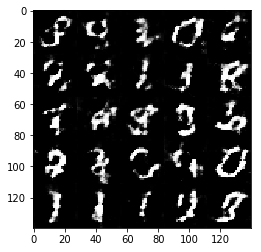

Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 1.2264
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 1.4996
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 1.3244
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.4364
Epoch 2/2... Discriminator Loss: 0.8913... Generator Loss: 1.4756
Epoch 2/2... Discriminator Loss: 1.0060... Generator Loss: 1.5070
Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 1.5436
Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 1.0376
Epoch 2/2... Discriminator Loss: 1.0343... Generator Loss: 1.3267


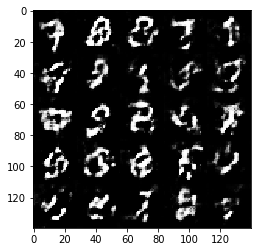

Epoch 2/2... Discriminator Loss: 1.1857... Generator Loss: 1.3071
Epoch 2/2... Discriminator Loss: 1.0979... Generator Loss: 1.4704
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 1.1558
Epoch 2/2... Discriminator Loss: 1.0512... Generator Loss: 1.2072
Epoch 2/2... Discriminator Loss: 1.0840... Generator Loss: 1.2687
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 1.2365
Epoch 2/2... Discriminator Loss: 1.0324... Generator Loss: 1.3853
Epoch 2/2... Discriminator Loss: 0.9502... Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 1.2253
Epoch 2/2... Discriminator Loss: 0.9788... Generator Loss: 1.4395


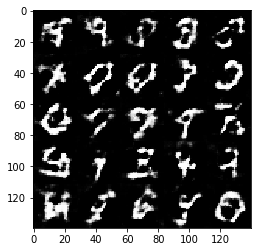

Epoch 2/2... Discriminator Loss: 1.1571... Generator Loss: 1.0969
Epoch 2/2... Discriminator Loss: 1.0367... Generator Loss: 1.2918
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.0871... Generator Loss: 1.1941
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 1.1382
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.4596
Epoch 2/2... Discriminator Loss: 1.0309... Generator Loss: 1.1889


In [12]:
"""review suggestion

注意我们的参数最好设置成2的倍数，比如4、8、16、32、64。这样可以让tensorflow在计算的时候进行优化，
让模型训练更加迅速。Batch size 主要影响的是你GAN生成的图片质量，下面给一些关于参数设置的建议：

● 对于celeA这个数据集来说，由于它包含了许多大图像，所以Batch size设置为16或者32比较合适。
● 对于MNIST这个数据集来说，图像相对较小，只是28 * 28 的黑白色图形，所以Batch size 设置为32 或者64。
● 在GAN中，learning rate 设置为0.0002应该不错，但是有些稍微提高一点能够有效地减少你训练的时间（0.001左右）。
● Beta1 在0.5或0.4左右的话也不错。

"""
batch_size = 64
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/1... Discriminator Loss: 2.2997... Generator Loss: 0.2505
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.5518... Generator Loss: 2.0298
Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 2.3273
Epoch 1/1... Discriminator Loss: 0.4908... Generator Loss: 2.3501
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.5393
Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 2.5799
Epoch 1/1... Discriminator Loss: 0.4327... Generator Loss: 2.5980
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 2.5944
Epoch 1/1... Discriminator Loss: 0.4729... Generator Loss: 2.4591


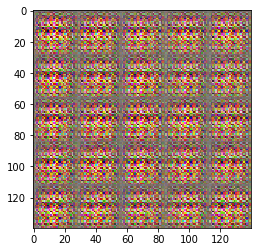

Epoch 1/1... Discriminator Loss: 0.4939... Generator Loss: 2.6806
Epoch 1/1... Discriminator Loss: 0.4615... Generator Loss: 2.6065
Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.3517
Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.9044
Epoch 1/1... Discriminator Loss: 0.3952... Generator Loss: 3.2512
Epoch 1/1... Discriminator Loss: 0.4363... Generator Loss: 3.6381
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 2.9463
Epoch 1/1... Discriminator Loss: 0.4478... Generator Loss: 2.6702
Epoch 1/1... Discriminator Loss: 0.4946... Generator Loss: 2.9131
Epoch 1/1... Discriminator Loss: 0.4347... Generator Loss: 3.0103


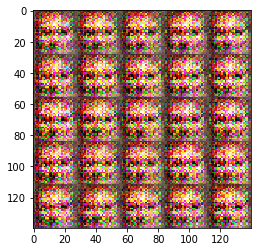

Epoch 1/1... Discriminator Loss: 0.5058... Generator Loss: 2.3767
Epoch 1/1... Discriminator Loss: 0.5146... Generator Loss: 4.6957
Epoch 1/1... Discriminator Loss: 0.4281... Generator Loss: 3.2042
Epoch 1/1... Discriminator Loss: 0.4804... Generator Loss: 3.1133
Epoch 1/1... Discriminator Loss: 0.4839... Generator Loss: 2.4721
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.6489
Epoch 1/1... Discriminator Loss: 0.5352... Generator Loss: 2.1494
Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 2.6912
Epoch 1/1... Discriminator Loss: 0.4857... Generator Loss: 2.7526
Epoch 1/1... Discriminator Loss: 1.0970... Generator Loss: 0.7844


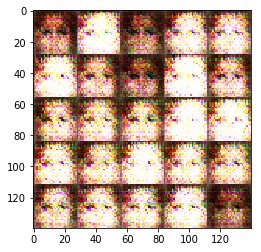

Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 1.7389
Epoch 1/1... Discriminator Loss: 0.5699... Generator Loss: 2.8061
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 3.1730
Epoch 1/1... Discriminator Loss: 0.5271... Generator Loss: 2.1825
Epoch 1/1... Discriminator Loss: 0.5648... Generator Loss: 2.0044
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.6705
Epoch 1/1... Discriminator Loss: 0.4432... Generator Loss: 3.0402
Epoch 1/1... Discriminator Loss: 0.4967... Generator Loss: 2.5699
Epoch 1/1... Discriminator Loss: 0.4891... Generator Loss: 2.9815
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 2.9334


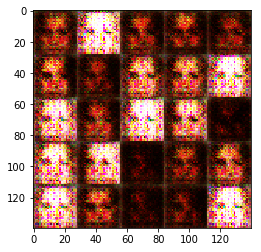

Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 3.7151
Epoch 1/1... Discriminator Loss: 0.4442... Generator Loss: 2.8830
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 2.9682
Epoch 1/1... Discriminator Loss: 0.4299... Generator Loss: 2.9604
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 2.2611
Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.5574
Epoch 1/1... Discriminator Loss: 0.4390... Generator Loss: 3.0046
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 0.4461... Generator Loss: 2.9372
Epoch 1/1... Discriminator Loss: 0.5091... Generator Loss: 2.1553


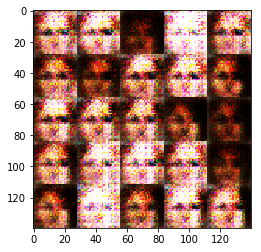

Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 3.0319
Epoch 1/1... Discriminator Loss: 0.4447... Generator Loss: 3.2276
Epoch 1/1... Discriminator Loss: 0.4348... Generator Loss: 3.0191
Epoch 1/1... Discriminator Loss: 0.4959... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 2.7010
Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 3.1676
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 2.1265
Epoch 1/1... Discriminator Loss: 0.5045... Generator Loss: 2.5227
Epoch 1/1... Discriminator Loss: 0.5227... Generator Loss: 2.5972
Epoch 1/1... Discriminator Loss: 0.4791... Generator Loss: 3.4317


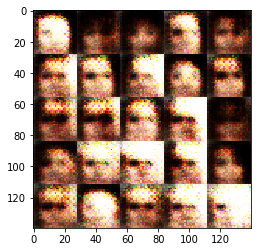

Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 2.8504
Epoch 1/1... Discriminator Loss: 0.6193... Generator Loss: 1.7461
Epoch 1/1... Discriminator Loss: 0.5206... Generator Loss: 2.9996
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 4.6249
Epoch 1/1... Discriminator Loss: 0.5307... Generator Loss: 2.9157
Epoch 1/1... Discriminator Loss: 0.6555... Generator Loss: 1.8702
Epoch 1/1... Discriminator Loss: 0.6148... Generator Loss: 1.8569
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 1.9287
Epoch 1/1... Discriminator Loss: 0.6953... Generator Loss: 1.9973


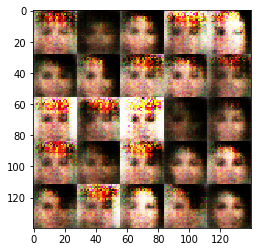

Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 2.6691
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 2.7442
Epoch 1/1... Discriminator Loss: 0.8496... Generator Loss: 1.0962
Epoch 1/1... Discriminator Loss: 0.7845... Generator Loss: 1.5864
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 3.1012
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 0.6558... Generator Loss: 1.7149
Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 0.6232... Generator Loss: 1.8228


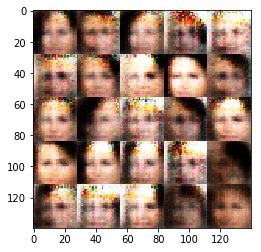

Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.4758
Epoch 1/1... Discriminator Loss: 0.6838... Generator Loss: 1.5665
Epoch 1/1... Discriminator Loss: 0.6830... Generator Loss: 2.6173
Epoch 1/1... Discriminator Loss: 0.8019... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 2.2031
Epoch 1/1... Discriminator Loss: 0.5655... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.6098... Generator Loss: 2.4898
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.6130
Epoch 1/1... Discriminator Loss: 0.5852... Generator Loss: 2.4210
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.2927


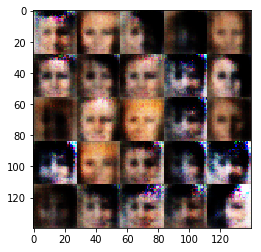

Epoch 1/1... Discriminator Loss: 0.6016... Generator Loss: 2.4494
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 2.3145
Epoch 1/1... Discriminator Loss: 0.9182... Generator Loss: 1.0198
Epoch 1/1... Discriminator Loss: 0.9390... Generator Loss: 0.9810
Epoch 1/1... Discriminator Loss: 1.1492... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 2.2176
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.4257
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.9584
Epoch 1/1... Discriminator Loss: 0.6540... Generator Loss: 1.8119
Epoch 1/1... Discriminator Loss: 0.7370... Generator Loss: 1.6839


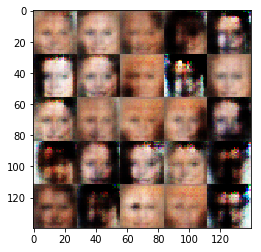

Epoch 1/1... Discriminator Loss: 0.5802... Generator Loss: 2.4963
Epoch 1/1... Discriminator Loss: 0.8231... Generator Loss: 2.3403
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 1.5612
Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.6605
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.3017
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.8055
Epoch 1/1... Discriminator Loss: 0.4848... Generator Loss: 3.5684
Epoch 1/1... Discriminator Loss: 0.8679... Generator Loss: 1.4859
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.8125


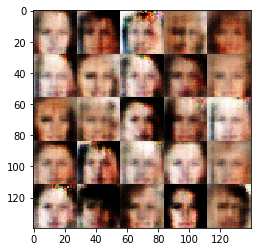

Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 3.1012
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.9802
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.2448
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 2.3262
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.9218
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 1.9248
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.4371
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 0.6568... Generator Loss: 1.9116
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.7312


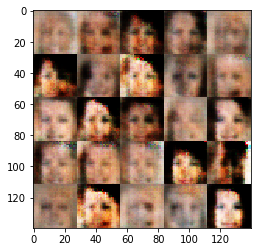

Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 2.3147
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.6051
Epoch 1/1... Discriminator Loss: 0.7569... Generator Loss: 1.9846
Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.5360
Epoch 1/1... Discriminator Loss: 0.7536... Generator Loss: 1.5079
Epoch 1/1... Discriminator Loss: 0.7227... Generator Loss: 1.3249
Epoch 1/1... Discriminator Loss: 0.8133... Generator Loss: 2.8795
Epoch 1/1... Discriminator Loss: 0.6605... Generator Loss: 3.2318
Epoch 1/1... Discriminator Loss: 0.7027... Generator Loss: 1.3768
Epoch 1/1... Discriminator Loss: 0.6245... Generator Loss: 2.3748


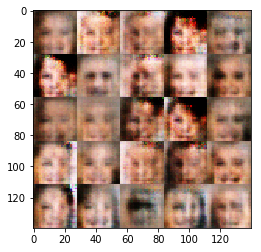

Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 1.7481
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.1900
Epoch 1/1... Discriminator Loss: 0.6491... Generator Loss: 1.7557
Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 2.4289
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 0.7294... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.8388
Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.8549


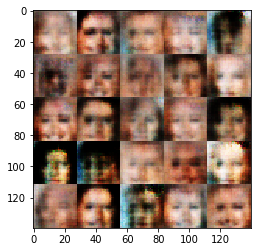

Epoch 1/1... Discriminator Loss: 0.8567... Generator Loss: 2.3307
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 2.7723
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 2.4971
Epoch 1/1... Discriminator Loss: 0.7995... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.4733
Epoch 1/1... Discriminator Loss: 0.6654... Generator Loss: 1.5963
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.6053
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.3254
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.5347
Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 2.6589


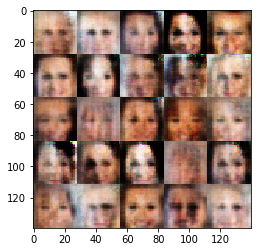

Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 1.8898
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 0.7984... Generator Loss: 1.5367
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 2.6957
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 1.5588
Epoch 1/1... Discriminator Loss: 0.7181... Generator Loss: 1.6447
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.6023
Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 1.0765


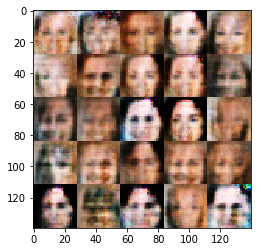

Epoch 1/1... Discriminator Loss: 0.6774... Generator Loss: 1.8797
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 0.7926... Generator Loss: 1.7405
Epoch 1/1... Discriminator Loss: 0.9661... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 2.1566
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.9045
Epoch 1/1... Discriminator Loss: 0.6341... Generator Loss: 2.3443
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.3037


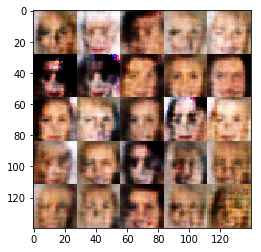

Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 2.0675
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.5649
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 2.2945
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 0.7092... Generator Loss: 1.4585
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 1.6986
Epoch 1/1... Discriminator Loss: 0.5310... Generator Loss: 2.8921
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 3.2929


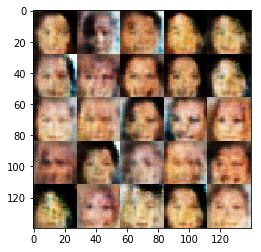

Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 2.3931
Epoch 1/1... Discriminator Loss: 0.6650... Generator Loss: 2.8001
Epoch 1/1... Discriminator Loss: 0.6935... Generator Loss: 1.9955
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.1282
Epoch 1/1... Discriminator Loss: 0.7937... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 0.6839... Generator Loss: 2.1212
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 2.0697
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 2.0136
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.3946
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 2.4803


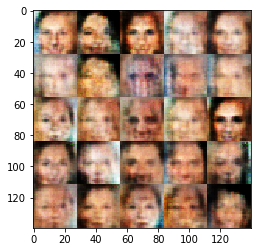

Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.7653
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.2721
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0986
Epoch 1/1... Discriminator Loss: 0.6461... Generator Loss: 1.9202
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 0.7684... Generator Loss: 1.2845
Epoch 1/1... Discriminator Loss: 0.9128... Generator Loss: 1.4592
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.1169
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 3.4382


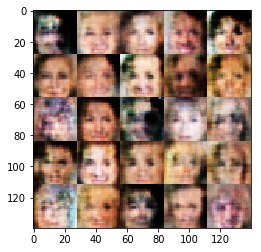

Epoch 1/1... Discriminator Loss: 0.8097... Generator Loss: 1.7370
Epoch 1/1... Discriminator Loss: 0.8468... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.5817
Epoch 1/1... Discriminator Loss: 0.8758... Generator Loss: 1.5135
Epoch 1/1... Discriminator Loss: 1.0665... Generator Loss: 1.7500
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 0.8641... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 2.4552
Epoch 1/1... Discriminator Loss: 0.6382... Generator Loss: 1.8901


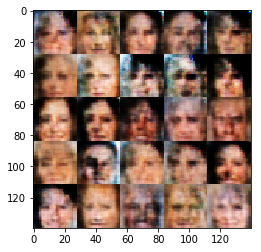

Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.8132
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.7359
Epoch 1/1... Discriminator Loss: 0.8972... Generator Loss: 1.8580
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.6306
Epoch 1/1... Discriminator Loss: 0.8491... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.8126
Epoch 1/1... Discriminator Loss: 0.7128... Generator Loss: 2.0345
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.2642
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 2.2603


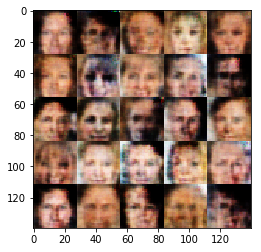

Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.5853
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.5744
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.2607
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 2.2621
Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.9391
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 1.4538
Epoch 1/1... Discriminator Loss: 0.8147... Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 1.6144
Epoch 1/1... Discriminator Loss: 0.7515... Generator Loss: 2.1376
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.5536


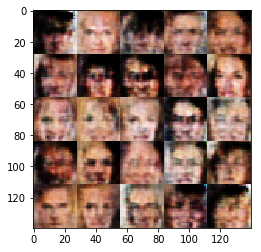

Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 0.7853... Generator Loss: 1.7390
Epoch 1/1... Discriminator Loss: 0.8251... Generator Loss: 1.7482
Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.8960
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 1.7264
Epoch 1/1... Discriminator Loss: 0.8059... Generator Loss: 1.4521
Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.2592
Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 2.2040
Epoch 1/1... Discriminator Loss: 0.8640... Generator Loss: 1.5560
Epoch 1/1... Discriminator Loss: 0.7617... Generator Loss: 1.7393


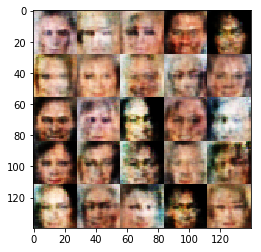

Epoch 1/1... Discriminator Loss: 0.8070... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.6549
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 2.6202
Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.5446
Epoch 1/1... Discriminator Loss: 0.7992... Generator Loss: 1.4817
Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 2.0899
Epoch 1/1... Discriminator Loss: 0.7268... Generator Loss: 1.5495
Epoch 1/1... Discriminator Loss: 0.7839... Generator Loss: 2.0163
Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.6618
Epoch 1/1... Discriminator Loss: 0.6537... Generator Loss: 2.5831


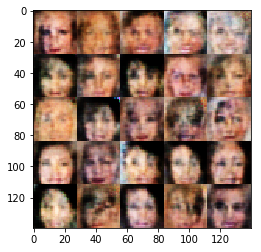

Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 1.5917
Epoch 1/1... Discriminator Loss: 0.7334... Generator Loss: 2.0267
Epoch 1/1... Discriminator Loss: 0.8849... Generator Loss: 1.1669
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 0.9304... Generator Loss: 1.2298
Epoch 1/1... Discriminator Loss: 0.8383... Generator Loss: 2.0900
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.1078
Epoch 1/1... Discriminator Loss: 0.6423... Generator Loss: 1.9251
Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.2891


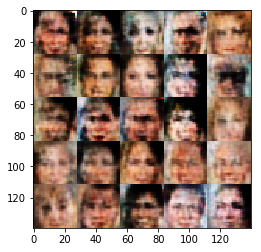

Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 0.6626... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 0.7545... Generator Loss: 1.9209
Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.7202
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.9457
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 2.3969
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.9553
Epoch 1/1... Discriminator Loss: 0.7721... Generator Loss: 1.7173
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 2.1276


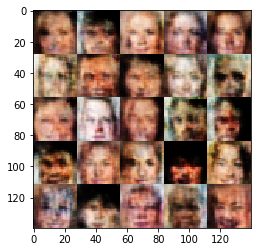

Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.8420
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 1.7502
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 2.2236
Epoch 1/1... Discriminator Loss: 0.7176... Generator Loss: 1.5544
Epoch 1/1... Discriminator Loss: 0.6894... Generator Loss: 1.2916
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 2.1929
Epoch 1/1... Discriminator Loss: 0.7258... Generator Loss: 2.1677
Epoch 1/1... Discriminator Loss: 0.7739... Generator Loss: 1.8023
Epoch 1/1... Discriminator Loss: 0.7200... Generator Loss: 2.2333


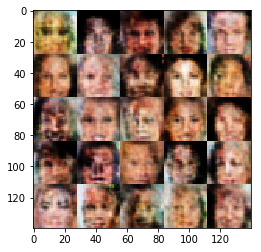

Epoch 1/1... Discriminator Loss: 0.7809... Generator Loss: 1.5929
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 2.0645
Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.2308
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.9056
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 2.1223
Epoch 1/1... Discriminator Loss: 0.7868... Generator Loss: 1.2854
Epoch 1/1... Discriminator Loss: 0.8614... Generator Loss: 1.7495
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.8230
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.1406


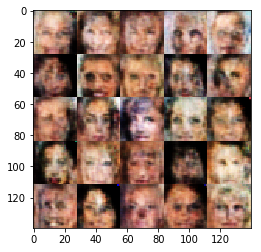

Epoch 1/1... Discriminator Loss: 0.8098... Generator Loss: 1.4003
Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 1.9989
Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2865
Epoch 1/1... Discriminator Loss: 0.9271... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 1.8006
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.5129
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.9525
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 2.4235
Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.9472
Epoch 1/1... Discriminator Loss: 0.8088... Generator Loss: 1.9657


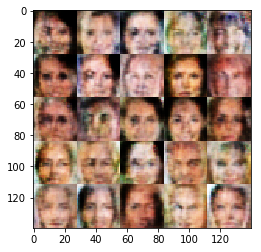

Epoch 1/1... Discriminator Loss: 0.9585... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.9087
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 1.5995
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 1.5950
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.1537
Epoch 1/1... Discriminator Loss: 0.8867... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.2726
Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.5894
Epoch 1/1... Discriminator Loss: 0.7674... Generator Loss: 1.8304
Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 2.2650


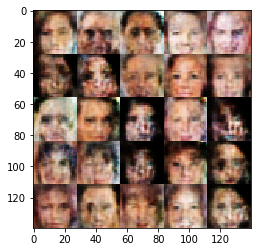

Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.3890
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 2.4882
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 2.4390
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.3059
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.7490
Epoch 1/1... Discriminator Loss: 0.8816... Generator Loss: 2.0888
Epoch 1/1... Discriminator Loss: 0.8561... Generator Loss: 1.7434
Epoch 1/1... Discriminator Loss: 0.6345... Generator Loss: 2.3827
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 1.2423


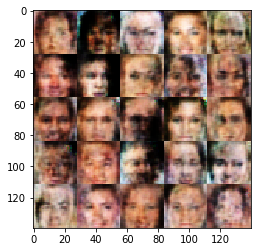

Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.3826
Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 2.2253
Epoch 1/1... Discriminator Loss: 0.8672... Generator Loss: 1.3972
Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 2.0586
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.6041
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.4620
Epoch 1/1... Discriminator Loss: 0.7468... Generator Loss: 1.3967
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.4789
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.8610


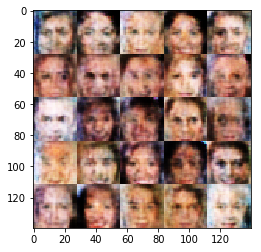

Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.5221
Epoch 1/1... Discriminator Loss: 0.7941... Generator Loss: 1.5164
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.9173
Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 2.7412
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.5678
Epoch 1/1... Discriminator Loss: 0.6974... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 2.7586
Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 2.4088
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.3980


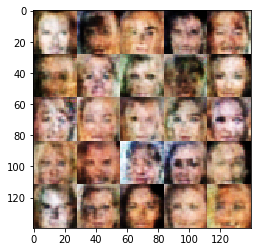

Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 2.0579
Epoch 1/1... Discriminator Loss: 0.7807... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 1.9951
Epoch 1/1... Discriminator Loss: 0.7988... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 2.4288
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.5905
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 0.9808
Epoch 1/1... Discriminator Loss: 0.5947... Generator Loss: 2.3174
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.4242
Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.7314


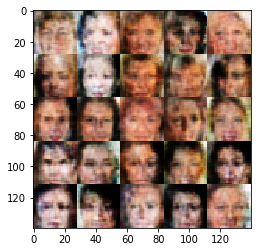

Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.6741
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 1.2709
Epoch 1/1... Discriminator Loss: 0.9600... Generator Loss: 1.7111
Epoch 1/1... Discriminator Loss: 0.7924... Generator Loss: 2.0668
Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.2290
Epoch 1/1... Discriminator Loss: 0.6179... Generator Loss: 2.8772
Epoch 1/1... Discriminator Loss: 0.8796... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 2.0476
Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.3838


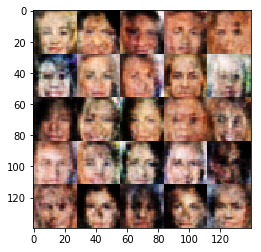

Epoch 1/1... Discriminator Loss: 0.6579... Generator Loss: 2.4391
Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.4909
Epoch 1/1... Discriminator Loss: 0.6870... Generator Loss: 1.4611
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 0.6460... Generator Loss: 1.6770
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.0765... Generator Loss: 1.2287
Epoch 1/1... Discriminator Loss: 0.8139... Generator Loss: 1.8932
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 2.1028
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.4028


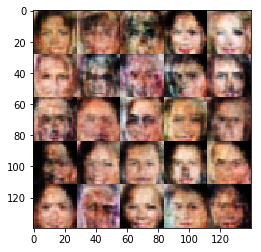

Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.6630
Epoch 1/1... Discriminator Loss: 0.8630... Generator Loss: 2.1320
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.4661
Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 0.8160... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 0.7418... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 0.5937... Generator Loss: 1.8190
Epoch 1/1... Discriminator Loss: 0.8122... Generator Loss: 2.6259
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.7762
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 2.0803


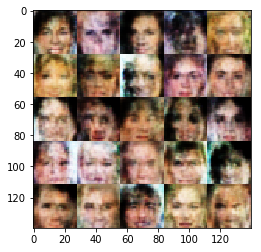

Epoch 1/1... Discriminator Loss: 0.7815... Generator Loss: 2.0385
Epoch 1/1... Discriminator Loss: 0.7106... Generator Loss: 2.1441
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 2.6458
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.5210
Epoch 1/1... Discriminator Loss: 0.6705... Generator Loss: 1.9487
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.5003
Epoch 1/1... Discriminator Loss: 0.6522... Generator Loss: 1.2487
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 0.7657... Generator Loss: 1.8678


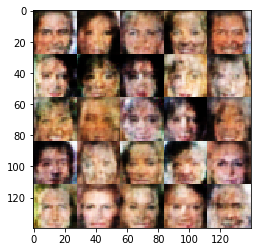

Epoch 1/1... Discriminator Loss: 0.6832... Generator Loss: 1.7496
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.6683... Generator Loss: 2.3259
Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 2.2923
Epoch 1/1... Discriminator Loss: 0.7433... Generator Loss: 2.0705
Epoch 1/1... Discriminator Loss: 0.6713... Generator Loss: 2.4227
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.2426
Epoch 1/1... Discriminator Loss: 0.7409... Generator Loss: 2.2121
Epoch 1/1... Discriminator Loss: 0.7756... Generator Loss: 1.5336
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 2.2515


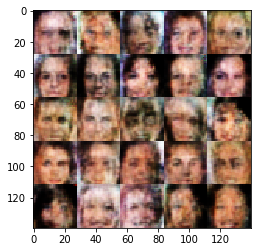

Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 1.8293
Epoch 1/1... Discriminator Loss: 0.6824... Generator Loss: 1.5640
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.9731
Epoch 1/1... Discriminator Loss: 0.7415... Generator Loss: 2.0697
Epoch 1/1... Discriminator Loss: 0.7835... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.4776
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.9846
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.7092
Epoch 1/1... Discriminator Loss: 0.8908... Generator Loss: 2.1613


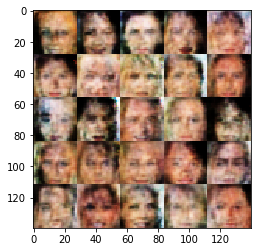

Epoch 1/1... Discriminator Loss: 0.5764... Generator Loss: 3.0229
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.0825
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.6205... Generator Loss: 1.5872
Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 2.4520
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 2.3248
Epoch 1/1... Discriminator Loss: 0.8954... Generator Loss: 2.9751
Epoch 1/1... Discriminator Loss: 0.5473... Generator Loss: 2.2793
Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 1.8737


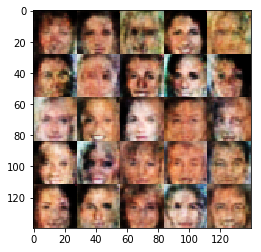

Epoch 1/1... Discriminator Loss: 0.6299... Generator Loss: 1.9079
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 2.4674
Epoch 1/1... Discriminator Loss: 0.7613... Generator Loss: 1.8439
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 0.7953... Generator Loss: 1.8347
Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 2.7601
Epoch 1/1... Discriminator Loss: 0.6004... Generator Loss: 2.1539
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 0.5539... Generator Loss: 2.0069


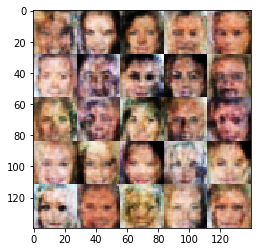

Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 0.8721... Generator Loss: 1.4826
Epoch 1/1... Discriminator Loss: 0.6983... Generator Loss: 2.1347
Epoch 1/1... Discriminator Loss: 0.7320... Generator Loss: 1.6166
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 2.2784
Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.8963
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.5286
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.6233
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.6718
Epoch 1/1... Discriminator Loss: 0.6622... Generator Loss: 1.5033


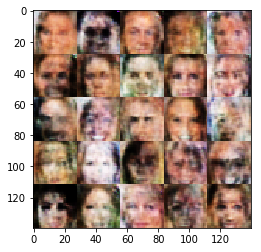

Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.7085
Epoch 1/1... Discriminator Loss: 0.7042... Generator Loss: 2.0018
Epoch 1/1... Discriminator Loss: 0.5978... Generator Loss: 1.8309
Epoch 1/1... Discriminator Loss: 0.6188... Generator Loss: 2.0329
Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 2.2062
Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 2.1850
Epoch 1/1... Discriminator Loss: 0.5826... Generator Loss: 2.7145
Epoch 1/1... Discriminator Loss: 0.5758... Generator Loss: 2.5833
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 1.2033


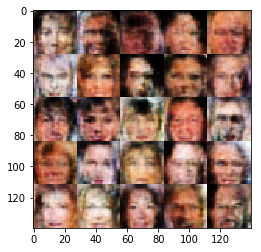

Epoch 1/1... Discriminator Loss: 0.7675... Generator Loss: 1.7792
Epoch 1/1... Discriminator Loss: 0.8947... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 0.6856... Generator Loss: 1.5119
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 2.5951
Epoch 1/1... Discriminator Loss: 0.5580... Generator Loss: 2.3924
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.9529
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.9013
Epoch 1/1... Discriminator Loss: 0.8085... Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.5266


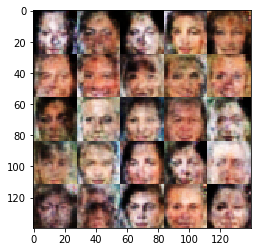

Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 1.7007
Epoch 1/1... Discriminator Loss: 0.7304... Generator Loss: 1.8056
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 0.7117... Generator Loss: 1.7458
Epoch 1/1... Discriminator Loss: 0.6017... Generator Loss: 2.3601
Epoch 1/1... Discriminator Loss: 0.6692... Generator Loss: 1.8577
Epoch 1/1... Discriminator Loss: 0.5809... Generator Loss: 2.2364
Epoch 1/1... Discriminator Loss: 0.6173... Generator Loss: 2.2466
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 2.3606
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 2.1139


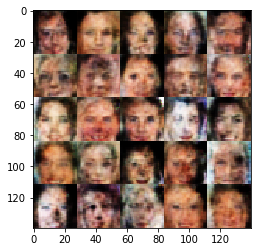

Epoch 1/1... Discriminator Loss: 0.6466... Generator Loss: 2.2025
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.7863
Epoch 1/1... Discriminator Loss: 0.5908... Generator Loss: 2.4823
Epoch 1/1... Discriminator Loss: 0.7447... Generator Loss: 1.9118
Epoch 1/1... Discriminator Loss: 0.7179... Generator Loss: 1.7869
Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 2.5844
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 2.1163
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 2.6354
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 2.3659


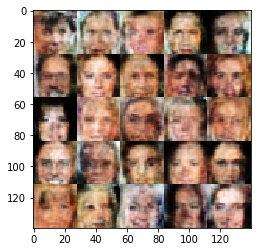

Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 1.7618
Epoch 1/1... Discriminator Loss: 0.6464... Generator Loss: 2.0854
Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.8103
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 1.9968
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.2012
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 0.7115... Generator Loss: 2.3792
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 2.5979
Epoch 1/1... Discriminator Loss: 0.8520... Generator Loss: 2.1543
Epoch 1/1... Discriminator Loss: 1.0101... Generator Loss: 1.1578


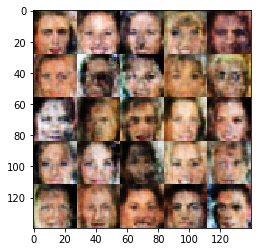

Epoch 1/1... Discriminator Loss: 0.8267... Generator Loss: 1.0649
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 2.7237
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 0.7464... Generator Loss: 1.7570
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 1.2855
Epoch 1/1... Discriminator Loss: 0.6225... Generator Loss: 1.7392
Epoch 1/1... Discriminator Loss: 0.6902... Generator Loss: 1.6785
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 1.8015
Epoch 1/1... Discriminator Loss: 0.7337... Generator Loss: 2.0682


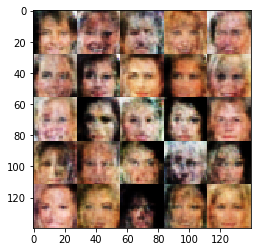

Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.8876
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.9025
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.4877
Epoch 1/1... Discriminator Loss: 0.6171... Generator Loss: 2.1781
Epoch 1/1... Discriminator Loss: 0.7603... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.7415
Epoch 1/1... Discriminator Loss: 0.6269... Generator Loss: 2.3819
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.4341
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.2246


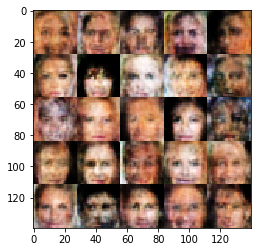

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.7328
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.2079
Epoch 1/1... Discriminator Loss: 0.6444... Generator Loss: 1.7887
Epoch 1/1... Discriminator Loss: 0.6219... Generator Loss: 2.6404
Epoch 1/1... Discriminator Loss: 0.8003... Generator Loss: 1.9493
Epoch 1/1... Discriminator Loss: 0.6703... Generator Loss: 2.0369
Epoch 1/1... Discriminator Loss: 0.5532... Generator Loss: 2.0185
Epoch 1/1... Discriminator Loss: 0.5250... Generator Loss: 2.2749
Epoch 1/1... Discriminator Loss: 0.7298... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.8354


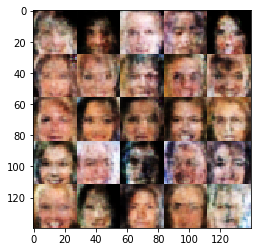

Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 2.3225
Epoch 1/1... Discriminator Loss: 0.6384... Generator Loss: 2.5627
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 1.8724
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.6962
Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.1325
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 2.5045
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 2.3289
Epoch 1/1... Discriminator Loss: 0.7659... Generator Loss: 1.8027
Epoch 1/1... Discriminator Loss: 0.5570... Generator Loss: 2.8133
Epoch 1/1... Discriminator Loss: 0.7976... Generator Loss: 1.8442


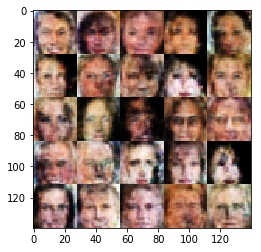

Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 2.0347
Epoch 1/1... Discriminator Loss: 0.5064... Generator Loss: 3.1316
Epoch 1/1... Discriminator Loss: 0.7623... Generator Loss: 1.8594
Epoch 1/1... Discriminator Loss: 0.5746... Generator Loss: 1.6363
Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 2.4239
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 0.8693... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 0.6142... Generator Loss: 2.3540
Epoch 1/1... Discriminator Loss: 0.5657... Generator Loss: 2.1329


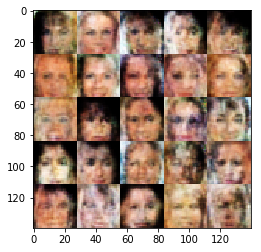

Epoch 1/1... Discriminator Loss: 0.6574... Generator Loss: 1.7962
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 2.9547
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 2.3888
Epoch 1/1... Discriminator Loss: 0.5039... Generator Loss: 1.9720
Epoch 1/1... Discriminator Loss: 0.7169... Generator Loss: 1.6759
Epoch 1/1... Discriminator Loss: 0.5492... Generator Loss: 2.4474
Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.8926
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 2.1586
Epoch 1/1... Discriminator Loss: 0.6387... Generator Loss: 1.8977
Epoch 1/1... Discriminator Loss: 0.7616... Generator Loss: 1.6957


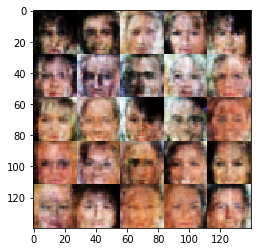

Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.8921
Epoch 1/1... Discriminator Loss: 0.6673... Generator Loss: 1.7266
Epoch 1/1... Discriminator Loss: 0.8659... Generator Loss: 1.7449
Epoch 1/1... Discriminator Loss: 0.5999... Generator Loss: 2.7227
Epoch 1/1... Discriminator Loss: 0.5862... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 2.3132
Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.3811
Epoch 1/1... Discriminator Loss: 0.5166... Generator Loss: 2.0552
Epoch 1/1... Discriminator Loss: 0.4800... Generator Loss: 2.7059
Epoch 1/1... Discriminator Loss: 0.6135... Generator Loss: 1.8772


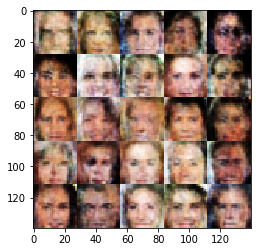

Epoch 1/1... Discriminator Loss: 0.6643... Generator Loss: 1.7774
Epoch 1/1... Discriminator Loss: 0.5897... Generator Loss: 2.0601
Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 2.2761
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.8393
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.5702
Epoch 1/1... Discriminator Loss: 0.6655... Generator Loss: 2.0226
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 2.0297
Epoch 1/1... Discriminator Loss: 0.6879... Generator Loss: 2.6283
Epoch 1/1... Discriminator Loss: 0.7002... Generator Loss: 1.3568
Epoch 1/1... Discriminator Loss: 0.7440... Generator Loss: 1.6241


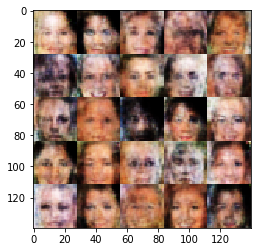

Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.5360
Epoch 1/1... Discriminator Loss: 0.5579... Generator Loss: 2.2716
Epoch 1/1... Discriminator Loss: 0.6273... Generator Loss: 2.2631
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 0.5062... Generator Loss: 3.6843
Epoch 1/1... Discriminator Loss: 0.6586... Generator Loss: 2.4080
Epoch 1/1... Discriminator Loss: 0.6169... Generator Loss: 1.9521
Epoch 1/1... Discriminator Loss: 0.4941... Generator Loss: 2.0467
Epoch 1/1... Discriminator Loss: 0.5794... Generator Loss: 2.2156
Epoch 1/1... Discriminator Loss: 0.8376... Generator Loss: 2.1529


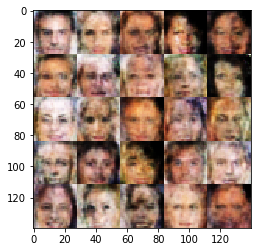

Epoch 1/1... Discriminator Loss: 0.5422... Generator Loss: 2.7639
Epoch 1/1... Discriminator Loss: 0.4965... Generator Loss: 1.9853
Epoch 1/1... Discriminator Loss: 0.5921... Generator Loss: 2.6587
Epoch 1/1... Discriminator Loss: 0.6682... Generator Loss: 2.1269
Epoch 1/1... Discriminator Loss: 0.5768... Generator Loss: 2.3896
Epoch 1/1... Discriminator Loss: 0.6609... Generator Loss: 2.4612
Epoch 1/1... Discriminator Loss: 0.5573... Generator Loss: 3.0983
Epoch 1/1... Discriminator Loss: 0.6064... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.3007
Epoch 1/1... Discriminator Loss: 0.5941... Generator Loss: 1.8626


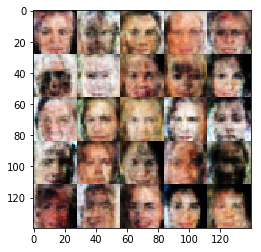

Epoch 1/1... Discriminator Loss: 0.6406... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.4625
Epoch 1/1... Discriminator Loss: 0.5901... Generator Loss: 1.8923
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 2.1086
Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 2.1032... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.4246
Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 2.1419
Epoch 1/1... Discriminator Loss: 0.5136... Generator Loss: 2.0559
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 2.4082


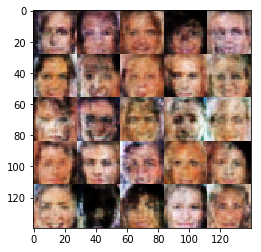

Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 1.5153
Epoch 1/1... Discriminator Loss: 0.5904... Generator Loss: 2.2682
Epoch 1/1... Discriminator Loss: 0.6020... Generator Loss: 2.5860
Epoch 1/1... Discriminator Loss: 0.4488... Generator Loss: 3.5533
Epoch 1/1... Discriminator Loss: 0.6215... Generator Loss: 1.8951
Epoch 1/1... Discriminator Loss: 0.6383... Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.7649
Epoch 1/1... Discriminator Loss: 0.4871... Generator Loss: 1.9021
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.8957


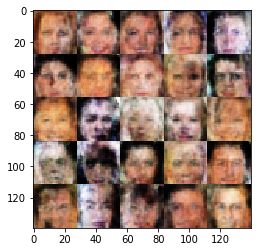

Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.8612
Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 2.1403
Epoch 1/1... Discriminator Loss: 0.7374... Generator Loss: 1.8898
Epoch 1/1... Discriminator Loss: 0.5001... Generator Loss: 1.9573
Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 0.5274... Generator Loss: 2.9202
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 2.3335
Epoch 1/1... Discriminator Loss: 0.5516... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 3.2937
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 1.9704


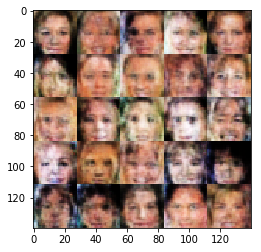

Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 3.2009
Epoch 1/1... Discriminator Loss: 0.4521... Generator Loss: 3.0677
Epoch 1/1... Discriminator Loss: 0.5053... Generator Loss: 1.6273
Epoch 1/1... Discriminator Loss: 0.5240... Generator Loss: 3.7291
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 2.6591
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 2.5086
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 2.4671
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.4016
Epoch 1/1... Discriminator Loss: 0.6150... Generator Loss: 2.0257
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 2.0548


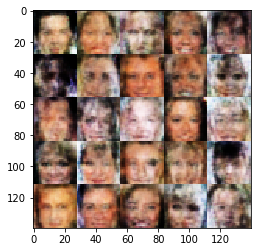

Epoch 1/1... Discriminator Loss: 0.5369... Generator Loss: 2.0503
Epoch 1/1... Discriminator Loss: 0.6704... Generator Loss: 2.3655
Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 2.6309


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。